In [1]:
import os
import numpy as np
import ta as ta_lib
import pandas as pd
import yfinance as yf
import pandas_ta as ta
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

pd.options.mode.use_inf_as_na = True

import quantstats as qs
qs.extend_pandas()

# filter warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
source_yahoo: bool = False

### 0. Get Daily OHLCV from YFinance

In [3]:
if source_yahoo:
    symbol = 'CCRO3.SA'

    df_daily = yf.download(symbol, period='2y', interval='1d').reset_index()

    # Drop Adj Close
    df_daily.drop(columns=['Adj Close'], inplace=True)

    # Renaming Datetime column
    df_daily = df_daily.rename(columns={'Datetime': 'Date'})

    display(df_daily.tail())

### 0.2 Get Hourly OHLCV from YFinance

In [4]:
if source_yahoo:
    df_hourly = yf.download(symbol, period='2y', interval='60m').reset_index()

    # Drop Adj Close
    df_hourly.drop(columns=['Adj Close'], inplace=True)

    # Renaming Datetime column
    df_hourly = df_hourly.rename(columns={'Datetime': 'date'})

    # Set date column as index
    df_hourly.set_index('date', inplace=True)

    # Filter hours
    hours = df_hourly.index.hour
    df_hourly = df_hourly.iloc[((hours >= 11) & (hours < 17))]

    df_hourly.index = df_hourly.index.tz_convert(None) - pd.Timedelta(hours=3)

    display(df_hourly.tail(10))

### 0. Get OHLCV hourly from QFLib

In [5]:
if not source_yahoo:

    ticker = 'PETR4'

    # Get Adjusted 1-min bars
    df = pd.read_parquet(f'../../data/market/ohlcv_minute/{ticker}.parquet')

    # Adjust Timestamp
    df.index = df.index.tz_convert(None) - pd.Timedelta(hours=3)

    # Filter Trading Hours (10h - 17h)
    hours = df.index.hour
    df = df.iloc[(hours >= 10) & (hours < 17)]

    # Resample - Daily Bars
    df_daily = df.resample('D').last().dropna()
    df_daily.columns = df_daily.columns.droplevel(1)
    df_daily.index = df_daily.index.rename('Date')
    df_daily = df_daily.drop(columns=['qty'])
    df_daily = df_daily.rename(columns={'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close', 'volume': 'Volume'})

    # Resample - 1 Hour Bars
    df_hourly = df.groupby(pd.Grouper(freq='1h')).last().dropna()
    df_hourly.columns = df_hourly.columns.droplevel(1)
    df_hourly.index = df_hourly.index.rename('Date')
    df_hourly = df_hourly.drop(columns=['qty'])
    df_hourly = df_hourly.rename(columns={'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close', 'volume': 'Volume'})

In [6]:
df_daily.tail()

,Open,High,Low,Close,Volume
Date,,,,,
2022-04-28,30.35,30.38,30.31,30.35,2851783.0
2022-04-29,30.48,30.52,30.47,30.49,7702595.0
2022-05-02,29.83,29.90,29.80,29.90,1971765.0
2022-05-03,30.24,30.24,30.23,30.23,4652612.0
2022-05-04,32.08,32.15,32.00,32.07,12304033.0


In [7]:
df_hourly.tail()

,Open,High,Low,Close,Volume
Date,,,,,
2022-05-04 12:00:00,30.90,30.93,30.90,30.92,2087082.0
2022-05-04 13:00:00,30.96,30.96,30.95,30.95,1194932.0
2022-05-04 14:00:00,31.04,31.07,31.02,31.03,2408691.0
2022-05-04 15:00:00,31.66,31.68,31.57,31.62,6640236.0
2022-05-04 16:00:00,32.08,32.15,32.00,32.07,12304033.0


### Feature Engineering

In [8]:
def fix_dataset_inconsistencies(dataframe, fill_value=None):
    """TODO"""
    dataframe = dataframe.replace([-np.inf, np.inf], np.nan)

    # This is done to avoid filling middle holes with backfilling.
    if fill_value is None:
        dataframe.iloc[0,:] = dataframe.apply(lambda column: column.iloc[column.first_valid_index()], axis='index')
    else:
        dataframe.iloc[0,:] = dataframe.iloc[0,:].fillna(fill_value)
        
    return dataframe.fillna(axis='index', method='pad').dropna(axis='columns')

def rsi(price: 'pd.Series[pd.Float64Dtype]', period: float) -> 'pd.Series[pd.Float64Dtype]':
    """TODO"""
    r = price.diff()
    upside = np.minimum(r, 0).abs()
    downside = np.maximum(r, 0).abs()
    rs = upside.ewm(alpha=1 / period).mean() / downside.ewm(alpha=1 / period).mean()
    
    return 100 * (1 - (1 + rs) ** -1)

def macd(price: 'pd.Series[pd.Float64Dtype]', fast: float, slow: float, signal: float) -> 'pd.Series[pd.Float64Dtype]':
    """TODO"""
    fm = price.ewm(span=fast, adjust=False).mean()
    sm = price.ewm(span=slow, adjust=False).mean()
    md = fm - sm
    signal = md - md.ewm(span=signal, adjust=False).mean()
    return signal

def generate_all_default_quantstats_features(data):
    """TODO"""
    
    excluded_indicators = [
        'compare',
        'greeks',
        'information_ratio',
        'omega',
        'r2',
        'r_squared',
        'rolling_greeks',
        'warn'
    ]
    
    indicators_list = [f for f in dir(qs.stats) if f[0] != '_' and f not in excluded_indicators]
    
    df = data.copy()
    df = df.set_index('date')
    df.index = pd.DatetimeIndex(df.index)

    for indicator_name in indicators_list:
        try:
            indicator = qs.stats.__dict__[indicator_name](df['Close'])
            if isinstance(indicator, pd.Series):
                indicator = indicator.to_frame(name=indicator_name)
                df = pd.concat([df, indicator], axis='columns')
        except (pd.errors.InvalidIndexError, ValueError):
            print (f'Error on indicator: {indicator_name}')
            pass

    df = df.reset_index()
    return df

def generate_features(data):
    """TODO"""

    # Automatically-generated using ta_lib
    df = data.copy()

    df.index = pd.DatetimeIndex(df.index)

    cores = os.cpu_count()
    df.ta.cores = cores

    # Generate all default indicators from ta library
    ta_lib.add_all_ta_features(data, 
                            'Open', 
                            'High', 
                            'Low', 
                            'Close', 
                            'Volume', 
                            fillna=True)

    # Custom indicators
    features = pd.DataFrame.from_dict({
        'prev_open': data['Open'].shift(1),
        'prev_high': data['High'].shift(1),
        'prev_low': data['Low'].shift(1),
        'prev_close': data['Close'].shift(1),
        'prev_volume': data['Volume'].shift(1),
        'vol_5': data['Close'].rolling(window=5).std().abs(),
        'vol_10': data['Close'].rolling(window=10).std().abs(),
        'vol_20': data['Close'].rolling(window=20).std().abs(),
        'vol_30': data['Close'].rolling(window=30).std().abs(),
        'vol_50': data['Close'].rolling(window=50).std().abs(),
        'vol_60': data['Close'].rolling(window=60).std().abs(),
        'vol_100': data['Close'].rolling(window=100).std().abs(),
        'vol_200': data['Close'].rolling(window=200).std().abs(),
        'ma_5': data['Close'].rolling(window=5).mean(),
        'ma_10': data['Close'].rolling(window=10).mean(),
        'ma_20': data['Close'].rolling(window=20).mean(),
        'ma_30': data['Close'].rolling(window=30).mean(),
        'ma_50': data['Close'].rolling(window=50).mean(),
        'ma_60': data['Close'].rolling(window=60).mean(),
        'ma_100': data['Close'].rolling(window=100).mean(),
        'ma_200': data['Close'].rolling(window=200).mean(),
        'ema_5': ta_lib.trend.ema_indicator(data['Close'], window=5, fillna=True),
        'ema_10': ta_lib.trend.ema_indicator(data['Close'], window=10, fillna=True),
        'ema_20': ta_lib.trend.ema_indicator(data['Close'], window=20, fillna=True),
        'ema_60': ta_lib.trend.ema_indicator(data['Close'], window=60, fillna=True),
        'ema_64': ta_lib.trend.ema_indicator(data['Close'], window=64, fillna=True),
        'ema_120': ta_lib.trend.ema_indicator(data['Close'], window=120, fillna=True),
        'lr_open': np.log(data['Open']).diff().fillna(0),
        'lr_high': np.log(data['High']).diff().fillna(0),
        'lr_low': np.log(data['Low']).diff().fillna(0),
        'lr_close': np.log(data['Close']).diff().fillna(0),
        'r_volume': data['Close'].diff().fillna(0),
        'rsi_5': rsi(data['Close'], period=5),
        'rsi_10': rsi(data['Close'], period=10),
        'rsi_100': rsi(data['Close'], period=100),
        'rsi_7': rsi(data['Close'], period=7),
        'rsi_28': rsi(data['Close'], period=28),
        'rsi_6': rsi(data['Close'], period=6),
        'rsi_14': rsi(data['Close'], period=14),
        'rsi_26': rsi(data['Close'], period=24),
        'macd_normal': macd(data['Close'], fast=12, slow=26, signal=9),
        'macd_short': macd(data['Close'], fast=10, slow=50, signal=5),
        'macd_long': macd(data['Close'], fast=200, slow=100, signal=50)
    })

    # Concatenate both manually and automatically generated features
    data = pd.concat([data, features], axis='columns').fillna(method='pad')

    # Remove potential column duplicates
    data = data.loc[:,~data.columns.duplicated()]

    # Revert naming convention
    data = data.rename(columns={'Open': 'open', 
                                'High': 'high', 
                                'Low': 'low', 
                                'Close': 'close', 
                                'Volume': 'volume'})

    # Concatenate both manually and automatically generated features
    data = pd.concat([data, df], axis='columns').fillna(method='pad')

    # Remove potential column duplicates
    data = data.loc[:,~data.columns.duplicated()]

    data = data.reset_index()
    
    # Revert naming convention
    data = data.rename(columns={'Date': 'date'})

    # Generate all default quantstats features
    df_quantstats = generate_all_default_quantstats_features(data)

    # Concatenate both manually and automatically generated features
    data = pd.concat([data, df_quantstats], axis='columns').fillna(method='pad')

    # Remove potential column duplicates
    data = data.loc[:,~data.columns.duplicated()]

    # A lot of indicators generate NaNs at the beginning of DataFrames, so remove them
    data = data.iloc[200:]
    data = data.reset_index(drop=True)

    data = fix_dataset_inconsistencies(data, fill_value=None)
    
    data.set_index('date', inplace=True)
    
    return data

In [9]:
data_daily = generate_features(df_daily)
data_daily.head()

,open,high,low,close,volume,volume_adi,volume_obv,volume_cmf,volume_fi,volume_em,...,Volume,compsum,implied_volatility,outliers,pct_rank,remove_outliers,rolling_sharpe,rolling_sortino,rolling_volatility,to_drawdown_series
date,,,,,,,,,,,,,,,,,,,,,
2019-04-10,21.026638,21.041230,21.019342,21.041230,1.423261e+06,7.670524e+07,1.240754e+08,0.304704,5.143427e+05,-0.375866,...,1.423261e+06,1.297428e+249,0.393265,30.216075,92.500000,21.041230,1.900800,3.162046,0.406469,-0.012329
2019-04-11,20.435674,20.457562,20.428378,20.450266,5.668805e+06,7.953964e+07,1.184066e+08,0.372396,-3.771465e+04,-0.302354,...,5.668805e+06,2.783018e+250,0.393265,30.216075,76.666667,20.450266,1.443984,2.315158,0.396897,-0.040068
2019-04-12,18.691966,18.728445,18.677375,18.721150,1.830960e+07,9.261793e+07,1.000970e+08,0.411719,-4.555102e+06,-0.485355,...,1.830960e+07,5.488432e+251,0.393265,30.216075,25.000000,18.721150,0.739883,1.102283,0.409570,-0.121233
2019-04-15,18.910842,18.940025,18.896250,18.918138,3.626036e+06,9.261793e+07,1.037230e+08,0.412731,-3.802332e+06,0.259832,...,3.626036e+06,1.093193e+253,0.393265,30.216075,30.000000,18.918138,0.723654,1.077620,0.409386,-0.111986
2019-04-16,19.392368,19.450735,19.377776,19.450735,2.712407e+06,9.533033e+07,1.064354e+08,0.399987,-3.052768e+06,1.334461,...,2.712407e+06,2.235661e+254,0.393265,30.216075,38.333333,19.450735,0.845345,1.264281,0.411157,-0.086986


<AxesSubplot:xlabel='date'>

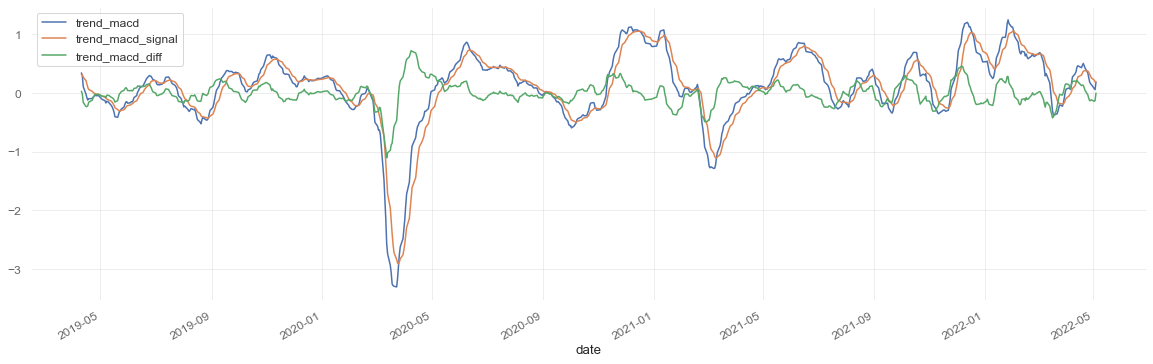

In [10]:
# BBANDS
data_daily[['trend_macd', 'trend_macd_signal', 'trend_macd_diff']].plot(figsize=(20,6))

In [11]:
columns_to_keep = [
    # OHLCV
    'open',
    'high',
    'low',
    'close',
    'volume',
    'prev_open',
    'prev_high',
    'prev_low',
    'prev_close',
    'prev_volume',
    # Volume Indicators (OBV, VWAP)
    'volume_obv',
    'volume_vwap',
    # Momentum Indicators (RSI)
    'momentum_rsi',
    # Strength Indicator (ADX, MACD)
    'trend_adx',
    'trend_macd',
    'trend_macd_signal',
    'trend_macd_diff',
    # Volatility Indicators (BBANDS)
    'volatility_bbm',
    'volatility_bbh',
    'volatility_bbl'
]

data_daily_final = data_daily[columns_to_keep]
data_daily_final.head()

,open,high,low,close,volume,prev_open,prev_high,prev_low,prev_close,prev_volume,volume_obv,volume_vwap,momentum_rsi,trend_adx,trend_macd,trend_macd_signal,trend_macd_diff,volatility_bbm,volatility_bbh,volatility_bbl
date,,,,,,,,,,,,,,,,,,,,
2019-04-10,21.026638,21.041230,21.019342,21.041230,1.423261e+06,21.281993,21.281993,21.267401,21.274697,1.650788e+06,1.240754e+08,20.576355,57.627850,17.720107,0.341864,0.313826,0.028038,20.666588,21.591594,19.741581
2019-04-11,20.435674,20.457562,20.428378,20.450266,5.668805e+06,21.026638,21.041230,21.019342,21.041230,1.423261e+06,1.184066e+08,20.632766,50.345594,16.482084,0.289917,0.309044,-0.019128,20.662210,21.590436,19.733985
2019-04-12,18.691966,18.728445,18.677375,18.721150,1.830960e+07,20.435674,20.457562,20.428378,20.450266,5.668805e+06,1.000970e+08,20.226938,36.007899,17.346592,0.107978,0.268831,-0.160853,20.567364,21.823857,19.310872
2019-04-15,18.910842,18.940025,18.896250,18.918138,3.626036e+06,18.691966,18.728445,18.677375,18.721150,1.830960e+07,1.037230e+08,20.121724,38.168275,17.816893,-0.020083,0.211048,-0.231131,20.463398,21.892570,19.034227
2019-04-16,19.392368,19.450735,19.377776,19.450735,2.712407e+06,18.910842,18.940025,18.896250,18.918138,3.626036e+06,1.064354e+08,20.105013,43.702257,17.492304,-0.077700,0.153299,-0.230999,20.370741,21.810188,18.931295


In [12]:
def generate_train_test_datasets(df, symbol, train_test_split, final_dir):
    """Get Yahoo! Finance Data for Train/Test Splits."""

    next_day = datetime.strptime(train_test_split, '%Y-%m-%d')
    next_day = next_day + timedelta(days=1)
    next_day = next_day.strftime('%Y-%m-%d')

    df_train = df.loc[:train_test_split].copy()
    df_test = df.loc[next_day:].copy()

    df_train.dropna().to_csv(f'../../data/market/{final_dir}/{symbol}_train.csv', index=True)
    df_test.dropna().to_csv(f'../../data/market/{final_dir}/{symbol}_test.csv', index=True)

    return df_train, df_test

#### Final OHLCV Daily Bars and TA

In [13]:
# 2020 - Now
data_daily_final = data_daily_final.loc['2020':]
data_daily_final.head()

,open,high,low,close,volume,prev_open,prev_high,prev_low,prev_close,prev_volume,volume_obv,volume_vwap,momentum_rsi,trend_adx,trend_macd,trend_macd_signal,trend_macd_diff,volatility_bbm,volatility_bbh,volatility_bbl
date,,,,,,,,,,,,,,,,,,,,
2020-01-02,22.991647,22.991647,22.976644,22.984146,1.101010e+06,22.676590,22.684091,22.676590,22.676590,1.038625e+06,1.459163e+08,22.483986,60.213023,14.856983,0.262897,0.237532,0.025365,22.401572,23.222685,21.580458
2020-01-03,22.991647,22.999148,22.969143,22.969143,2.502591e+06,22.991647,22.991647,22.976644,22.984146,1.101010e+06,1.434137e+08,22.532295,59.937179,15.263311,0.272904,0.244606,0.028297,22.468222,23.245208,21.691236
2020-01-06,23.119170,23.119170,23.104167,23.111669,3.388498e+06,22.991647,22.999148,22.969143,22.969143,2.502591e+06,1.468022e+08,22.609857,61.730805,15.857396,0.289003,0.253486,0.035517,22.550155,23.229546,21.870763
2020-01-07,23.006650,23.014151,23.006650,23.006650,2.715070e+05,23.119170,23.119170,23.104167,23.111669,3.388498e+06,1.465307e+08,22.603351,59.612978,16.123563,0.289945,0.260778,0.029168,22.609412,23.228297,21.990527
2020-01-08,22.819116,22.826617,22.811614,22.819116,9.652764e+05,23.006650,23.014151,23.006650,23.006650,2.715070e+05,1.455654e+08,22.658931,55.923385,15.814466,0.272420,0.263106,0.009314,22.631487,23.247213,22.015761


In [14]:
df_train, df_test = generate_train_test_datasets(data_daily_final, 'PETR3', '2021-10-01', 'ohlcv_daily_TA')
print ('Train: ', df_train.shape)
print ('Test: ', df_test.shape)

Train:  (436, 20)
Test:  (144, 20)


In [15]:
df_train.tail()

,open,high,low,close,volume,prev_open,prev_high,prev_low,prev_close,prev_volume,volume_obv,volume_vwap,momentum_rsi,trend_adx,trend_macd,trend_macd_signal,trend_macd_diff,volatility_bbm,volatility_bbh,volatility_bbl
date,,,,,,,,,,,,,,,,,,,,
2021-09-27,22.280323,22.304969,22.017428,22.296754,1.089759e+07,22.157091,22.181738,22.140660,22.140660,1.090501e+07,3.653309e+08,21.064192,57.007413,13.079931,-0.047567,-0.168784,0.121217,21.508481,23.012259,20.004702
2021-09-28,22.091367,22.140660,22.091367,22.132445,4.117369e+06,22.280323,22.304969,22.017428,22.296754,1.089759e+07,3.612136e+08,21.126654,55.200617,12.804867,0.003076,-0.134412,0.137488,21.448919,22.739667,20.158170
2021-09-29,22.477494,22.535002,22.469279,22.469279,1.962891e+06,22.091367,22.140660,22.091367,22.132445,4.117369e+06,3.631764e+08,21.173967,58.130272,13.053446,0.069589,-0.093612,0.163201,21.451794,22.751336,20.152252
2021-09-30,22.354262,22.378909,22.329616,22.346047,3.390637e+06,22.477494,22.535002,22.469279,22.469279,1.962891e+06,3.597858e+08,21.230541,56.670144,13.045099,0.111077,-0.052674,0.163751,21.460420,22.781129,20.139712
2021-10-01,22.970422,23.003283,22.970422,22.978637,3.791736e+07,22.354262,22.378909,22.329616,22.346047,3.390637e+06,3.977032e+08,21.728472,61.953259,13.794503,0.192779,-0.003583,0.196362,21.517928,22.989304,20.046553


In [16]:
df_test.head()

,open,high,low,close,volume,prev_open,prev_high,prev_low,prev_close,prev_volume,volume_obv,volume_vwap,momentum_rsi,trend_adx,trend_macd,trend_macd_signal,trend_macd_diff,volatility_bbm,volatility_bbh,volatility_bbl
date,,,,,,,,,,,,,,,,,,,,
2021-10-04,23.660520,23.668735,23.537288,23.578365,1.989671e+07,22.970422,23.003283,22.970422,22.978637,3.791736e+07,4.175999e+08,21.985688,66.165209,15.160032,0.302435,0.057620,0.244815,21.622265,23.345733,19.898796
2021-10-05,24.169878,24.178094,24.120586,24.153448,1.635549e+07,23.660520,23.668735,23.537288,23.578365,1.989671e+07,4.339554e+08,22.203112,69.636402,16.867888,0.430777,0.132252,0.298525,21.744675,23.791723,19.697627
2021-10-06,23.570150,23.586581,23.570150,23.570150,4.341548e+06,24.169878,24.178094,24.120586,24.153448,1.635549e+07,4.296138e+08,22.248807,62.619145,17.495023,0.479890,0.201779,0.278110,21.896250,24.011452,19.781049
2021-10-07,23.586581,23.619443,23.561935,23.611227,1.346430e+06,23.570150,23.586581,23.570150,23.570150,4.341548e+06,4.309602e+08,22.315920,62.902656,18.110115,0.516176,0.264659,0.251518,22.028930,24.223398,19.834462
2021-10-08,23.915199,23.923415,23.882337,23.882337,2.034381e+06,23.586581,23.619443,23.561935,23.611227,1.346430e+06,4.329946e+08,22.475006,64.800191,18.986755,0.560351,0.323797,0.236554,22.177630,24.449881,19.905379


AttributeError: 'DataFrame' object has no attribute 'rsi_14'

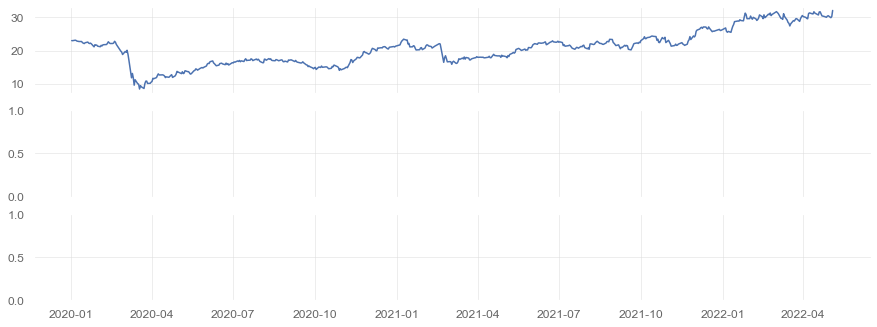

In [17]:
fig, ax = plt.subplots(3, sharex=True, figsize=(15,6))
data_daily_final.close.plot(ax=ax[0])

data_daily_final.rsi_14.plot(ax=ax[1], color='orange')
ax[1].axhline(30)
ax[1].axhline(70)

data_daily_final['trend_adx'].plot(ax=ax[2])

plt.tight_layout();

In [ ]:
data_daily_final.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 580 entries, 2020-01-02 to 2022-05-04
Columns: 148 entries, open to to_drawdown_series
dtypes: float64(148)
memory usage: 675.2 KB


In [ ]:
data_daily.shape

(761, 148)

In [ ]:
# Renaming columns
df_hourly = df_hourly.rename(columns={'Open': 'open', 'High': 'high', 'Low': 'low', 'Close': 'close', 'Volume': 'volume'})

In [ ]:
# Daily OHLCV with Technical Indicators
data_daily_hourly = data_daily_final.resample('H').pad()

# Merge Daily info into Hourly Prices
# TODO: Merge do 'data_daily_hourly' em 'df_hourly'
# data_daily_hourly = df_hourly.merge(data_daily_hourly, left_index=True, right_index=True, how='inner')

# Filter 
hour = data_daily_hourly.index.hour
data_daily_hourly = data_daily_hourly.iloc[((hour >= 11) & (hour < 17))]

In [ ]:
data_daily_hourly

,open,high,low,close,volume,volume_adi,volume_obv,volume_cmf,volume_fi,volume_em,...,Volume,compsum,implied_volatility,outliers,pct_rank,remove_outliers,rolling_sharpe,rolling_sortino,rolling_volatility,to_drawdown_series
date,,,,,,,,,,,,,,,,,,,,,
2020-01-02 11:00:00,22.991647,22.991647,22.976644,22.984146,1.101010e+06,1.037431e+08,1.459163e+08,0.205507,170138.938921,0.413974,...,1.101010e+06,1.123470e+308,0.292069,30.216075,100.000000,22.984146,1.197480,1.872513,0.261608,0.000000
2020-01-02 12:00:00,22.991647,22.991647,22.976644,22.984146,1.101010e+06,1.037431e+08,1.459163e+08,0.205507,170138.938921,0.413974,...,1.101010e+06,1.123470e+308,0.292069,30.216075,100.000000,22.984146,1.197480,1.872513,0.261608,0.000000
2020-01-02 13:00:00,22.991647,22.991647,22.976644,22.984146,1.101010e+06,1.037431e+08,1.459163e+08,0.205507,170138.938921,0.413974,...,1.101010e+06,1.123470e+308,0.292069,30.216075,100.000000,22.984146,1.197480,1.872513,0.261608,0.000000
2020-01-02 14:00:00,22.991647,22.991647,22.976644,22.984146,1.101010e+06,1.037431e+08,1.459163e+08,0.205507,170138.938921,0.413974,...,1.101010e+06,1.123470e+308,0.292069,30.216075,100.000000,22.984146,1.197480,1.872513,0.261608,0.000000
2020-01-02 15:00:00,22.991647,22.991647,22.976644,22.984146,1.101010e+06,1.037431e+08,1.459163e+08,0.205507,170138.938921,0.413974,...,1.101010e+06,1.123470e+308,0.292069,30.216075,100.000000,22.984146,1.197480,1.872513,0.261608,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-03 12:00:00,30.240000,30.240000,30.230000,30.230000,4.652612e+06,3.907147e+08,4.461139e+08,-0.234266,-22634.519556,0.082749,...,4.652612e+06,1.123470e+308,0.345780,30.230000,55.833333,29.566365,1.548707,2.377526,0.364706,-0.046878
2022-05-03 13:00:00,30.240000,30.240000,30.230000,30.230000,4.652612e+06,3.907147e+08,4.461139e+08,-0.234266,-22634.519556,0.082749,...,4.652612e+06,1.123470e+308,0.345780,30.230000,55.833333,29.566365,1.548707,2.377526,0.364706,-0.046878
2022-05-03 14:00:00,30.240000,30.240000,30.230000,30.230000,4.652612e+06,3.907147e+08,4.461139e+08,-0.234266,-22634.519556,0.082749,...,4.652612e+06,1.123470e+308,0.345780,30.230000,55.833333,29.566365,1.548707,2.377526,0.364706,-0.046878


---

In [ ]:
fig, ax = plt.subplots(figsize=(20,6))
data_daily_hourly.loc['2021':].close.plot(ax=ax)
ax.set_title(f'{symbol[:5]} Closing Prices')
ax.set_ylabel('Price (R$)')
ax.set_xlabel('Date')
plt.legend()
plt.tight_layout();